## Mod 6 Lecture 4 Data Challenge:  Simple Linear Regression

### Purpose

**Purpose**: Run a simple linear regression (SLR) on the NYC Yellow Taxi Dec 2023 excerpt to explain how a single input (X) relates to Tip % (Y). Practice picking a sensible X, fitting the line, and interpreting β₁, p‑value, and 95% confidence interval—plus basic assumption checks.

### Data
We are looking at ONE month's worth of data (December 2023 to be exact).  Remember the data dictionary is found [HERE](https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data)

### Instructor Guidance (10 Minutes)

#### Goals

- Pick an X with a plausible relationship to Tip % that is available at trip time.

- Communicate β₁ with units, p-vale, and a 95% CI.

#### Special considerations

- `Tip %` is `tip_amount / fare_amount`. Choosing `fare_amount` as X can create a built‑in relationship because it’s in the definition of Y (mathematical coupling). Encourage alternative X’s like `trip_distance`, `pickup_hour (as numeric)`, or `passenger_count`.

- Linearity check: Is the relationship roughly straight‑line? If X is discrete (e.g., passenger_count), SLR still works but discuss meaning.

- Intercept meaning: If X=0 is unrealistic (0 miles), say the intercept is just a mathematical anchor.

- Outliers: Large distances/fares can dominate. Consider trimming extremes thoughtfully or explaining how you would handle outliers.  

#### Critical thinking prompts as you work through the challenge (be prepared to answer at the end):

- Which input would you use to make a decision before the ride starts? Why?

- If β₁ is tiny but the p‑value is very small, is that useful for the business?

- If residuals (can only get residuals after fitting the model) "fan out" as X grows, what story might that tell about tipping behavior?

- Would your conclusion change if you looked at daytime vs. late night rides separately?

### Student Tasks (35 minutes)

Step 0 — Load Packages and Data, Fix Data Types, Create Tip % Column 

**Hint**:  You did this in the Code-Along, refer back to the notebook to help you!

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [19]:
path = '/Users/Marcy_Student/Desktop/Marcy-Modules/marcy-git/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv'

df = pd.read_csv(path)

# Coerce fare, tip, distance to numeric safely
num_cols = ['fare_amount', 'tip_amount', 'trip_distance']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce'
)

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_80907/2623774447.py:3: DtypeWarning: Columns (4,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Step 1 — Choose Your X (be sure to chose an X variable that would be available at trip time (not after the trip takes place))

Add a 2–3 sentence rationale in Markdown: Why could X relate to `tip_pct`? Why is it available **when the decision is made** (meaning driver has the information before the actual drive takes place)?

In [20]:
df['passenger_count'] = pd.to_numeric(df['passenger_count'].astype(str).str.strip().replace(to_replace='nan', value=0, regex=True), errors='coerce')
df['passenger_count'] = df['passenger_count'].astype(int)

df.dtypes

# Choosing my X to be passenger type. X can relate to tip_pct because there is a chance that the amount of passengers could affect how much tip is given. For example, more passengers
# carry more money between themselves, so there is a chance that the driver could receive more tips.

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount              object
congestion_surcharge     float64
airport_fee              float64
dtype: object

In [21]:
df = df[(df['fare_amount'] > 0) & (df['tip_amount'] >= 0) & (df['trip_distance'] > 0)]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=num_cols)
df['tip_pct'] = (df['tip_amount']/df['fare_amount']).clip(0,1)

Step 2 — Quick Visual Check (Linearity & Outliers)

Add a 2-3 sentence rationale on how you would handle outliers or how you did handle outliers (if you handled them for this challenge).  Is the linear relationship there between your X and Y?  Is it a strong relationship?  What is the benefits of a strong relationship between X and Y?

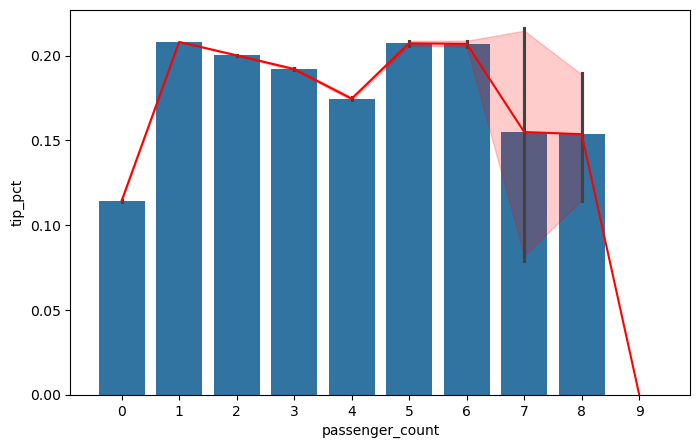

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(data=df, x='passenger_count', y='tip_pct')
sns.lineplot(data=df, x='passenger_count', y='tip_pct', color='red')
plt.show()

<div align='center'>
After viewing the chart, it is clear that 9 is an outlier that must be dealt with before modeling. Furthermore, there does not seem to be a strong, linear relationship between X and Y because the Y value varies inconsistently as X increases.

</div>

Step 3 — Fit SLR Model to Data

In [23]:
df = df[df['passenger_count']<9]
df['passenger_count'].value_counts()

passenger_count
1    2241854
2     492114
0     184424
3     131626
4      88324
5      38374
6      23506
8         24
7          8
Name: count, dtype: int64

In [24]:
X = sm.add_constant(df[['passenger_count']]) #add intercept yourself for statsmodels
y = df['tip_pct']
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tip_pct   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1511.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:34:31   Log-Likelihood:             1.7475e+06
No. Observations:             3200254   AIC:                        -3.495e+06
Df Residuals:                 3200252   BIC:                        -3.495e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1955      0.000   1426.914      0.000       0.195       0.196
passenger_count     0.0032   8.35e-05     38.866      0.000       0.003       0.003
==============================================================================
Omnibus:                    68519.206   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           122498.153
Skew:                           0.174   Prob(JB):                         0.00
Kurtosis:                       3.893   Cond. No.                         3.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Step 4 — Interpret the model's coefficients, p-values, and CI 

Double-click cell to type in your answer

Step 5 — Post‑Fit Assumption Glance 

Add 2-3 sentences about the residuals any curve? funnel shape? obvious outliers?  How would you go about checking if residuals were normally distributed?  

In [25]:
#RUN THIS CELL WITHOUT CHANGES
resid = ols.resid
fitted = ols.fittedvalues
plt.figure(figsize=(5,4))
plt.scatter(fitted, resid, s=6, alpha=0.3)
plt.axhline(0, color='k', lw=1)
plt.xlabel('Fitted values (tip_pct)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (visual check)')
plt.show()

NameError: name 'ols' is not defined

### Reflection (10-15 mins)

**In addition to the critical thinking questions at the top** of the notebook be prepared to discuss: 

- If you had to make a decision tomorrow, would this simple model be enough? Why/why not?

- What’s one different X you’d try next and why?